<a href="https://colab.research.google.com/github/febryandrias/tugas-akhir-bioinformatika/blob/main/Tugas_Besar_Bioinformatika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BAGIAN 1 — IMPORT LIBRARIES & MOUNT GOOGLE DRIVE

In [27]:
# ================================================================
# 1. PENGAMBILAN DATA
# IMPORT LIBRARIES & MOUNT GOOGLE DRIVE
# ================================================================

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO

Mounted at /content/drive


BAGIAN 2 — SET PATH FOLDER FASTA DI GOOGLE DRIVE

In [28]:
# ================================================================
# 2. SET PATH DATASET FASTA
# ================================================================

DRIVE_FOLDER = "/content/drive/MyDrive/Tugas Besar Bioinformatika"
OUTPUT_FOLDER = os.path.join(DRIVE_FOLDER, "output")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print("Folder FASTA:", DRIVE_FOLDER)
print("Folder Output:", OUTPUT_FOLDER)

Folder FASTA: /content/drive/MyDrive/Tugas Besar Bioinformatika
Folder Output: /content/drive/MyDrive/Tugas Besar Bioinformatika/output


BAGIAN 3 — LOAD SEMUA FILE FASTA

In [29]:
# ================================================================
# 3. LOAD SEMUA FILE FASTA (PENGAMBILAN DATA)
# ================================================================

exts = ("*.fasta","*.fa","*.fna","*.ffn")
fasta_paths = []
for e in exts:
    fasta_paths += glob.glob(os.path.join(DRIVE_FOLDER, e))

if len(fasta_paths) == 0:
    raise Exception("Tidak ada file FASTA ditemukan!")

records = []
for path in tqdm(fasta_paths):
    for rec in SeqIO.parse(path, "fasta"):
        records.append({
            "id": rec.id,
            "source": os.path.basename(path),
            "raw_seq": str(rec.seq)
        })

df = pd.DataFrame(records).set_index("id")
print("Total sequence:", len(df))

100%|██████████| 21/21 [00:00<00:00, 204.76it/s]

Total sequence: 21


BAGIAN 4 — PREPROCESSING DNA

In [30]:
# ================================================================
# 4. PRE-PROCESSING DATA DNA
# ================================================================

import re

def clean_seq(seq):
    seq = seq.upper()
    seq = re.sub(r"[^ACGT]", "", seq)
    return seq

df["seq"] = df["raw_seq"].apply(clean_seq)
df["length"] = df["seq"].apply(len)

BAGIAN 5 — EKSTRAKSI FITUR (K-MER, GC %, LENGTH, FREKUENSI BASA)
---



In [31]:
# ================================================================
# 5. EKSTRAKSI FITUR (k-mer, GC content, panjang, ACGT)
# ================================================================

from itertools import product

k = 3
bases = ["A","C","G","T"]
kmers = ["".join(p) for p in product(bases, repeat=k)]
k_index = {kmer:i for i,kmer in enumerate(kmers)}

def seq_to_kmer(seq):
    vec = np.zeros(len(kmers))
    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]
        if kmer in k_index:
            vec[k_index[kmer]] += 1
    return vec / vec.sum() if vec.sum() > 0 else vec

def gc_content(seq):
    return 100*(seq.count("G")+seq.count("C"))/len(seq) if len(seq)>0 else 0

kvecs = np.vstack(df["seq"].apply(seq_to_kmer))
gc = np.array(df["seq"].apply(gc_content)).reshape(-1,1)
length = df["length"].values.reshape(-1,1)

A = np.array(df["seq"].apply(lambda s: s.count("A")/max(1,len(s)))).reshape(-1,1)
C = np.array(df["seq"].apply(lambda s: s.count("C")/max(1,len(s)))).reshape(-1,1)
G = np.array(df["seq"].apply(lambda s: s.count("G")/max(1,len(s)))).reshape(-1,1)
T = np.array(df["seq"].apply(lambda s: s.count("T")/max(1,len(s)))).reshape(-1,1)

X = np.hstack([kvecs, gc, length, A, C, G, T])
df["GC"] = gc.flatten()

print("Dimensi fitur:", X.shape)

Dimensi fitur: (21, 70)


BAGIAN 6 — NORMALISASI + PCA (VISUALISASI DATA)

In [32]:
# ================================================================
# 6. NORMALISASI & PCA
# ================================================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:,0]
df["PC2"] = X_pca[:,1]

BAGIAN 7 — CLUSTERING (K-MEANS + SILHOUETTE SCORE)

In [33]:
# ================================================================
# 7. PENERAPAN CLUSTERING (K-MEANS)
# ================================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k, best_score = None, -1

for k_try in range(2,7):
    km = KMeans(n_clusters=k_try, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score, best_k = score, k_try

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

print("Jumlah cluster optimal:", best_k)

Jumlah cluster optimal: 4


BAGIAN 8 — DISTRIBUSI KELAS DATASET (HASIL CLUSTERING)

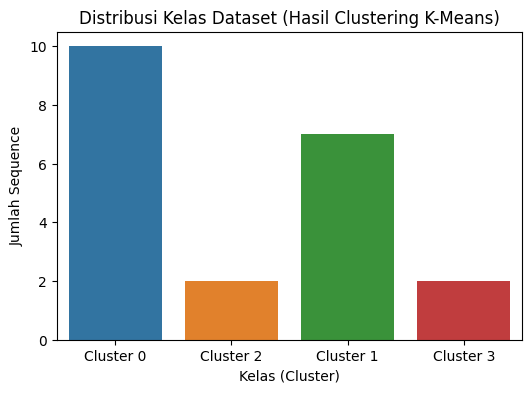

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat label cluster lebih jelas
df["cluster_label"] = df["cluster"].apply(lambda x: f"Cluster {x}")

plt.figure(figsize=(6,4))
sns.countplot(x="cluster_label", data=df, palette="tab10")
plt.title("Distribusi Kelas Dataset (Hasil Clustering K-Means)")
plt.xlabel("Kelas (Cluster)")
plt.ylabel("Jumlah Sequence")
plt.show()


BAGIAN 9 — POHON FILOGENETIK (DENDROGRAM)

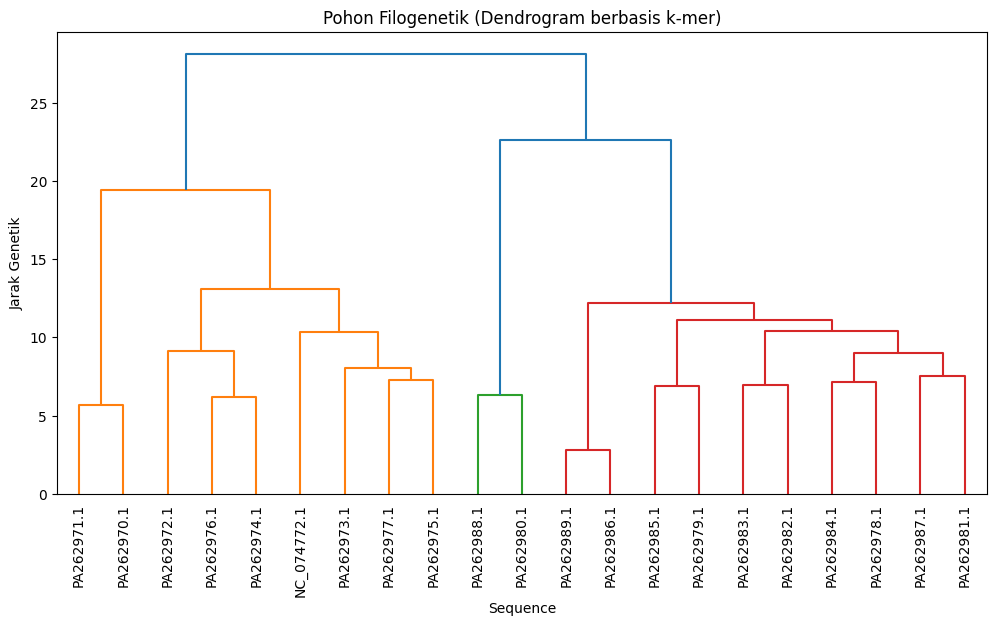

In [35]:
# ================================================================
# 9. POHON FILOGENETIK (DENDROGRAM)
# ================================================================

from scipy.cluster.hierarchy import dendrogram, linkage

X_dendro = X_scaled[:min(30, len(X_scaled))]
linkage_matrix = linkage(X_dendro, method="ward")

plt.figure(figsize=(12,6))
dendrogram(linkage_matrix, labels=df.index[:len(X_dendro)], leaf_rotation=90)
plt.title("Pohon Filogenetik (Dendrogram berbasis k-mer)")
plt.xlabel("Sequence")
plt.ylabel("Jarak Genetik")
plt.show()

BAGIAN 10 — MODEL MACHINE LEARNING KLASIK

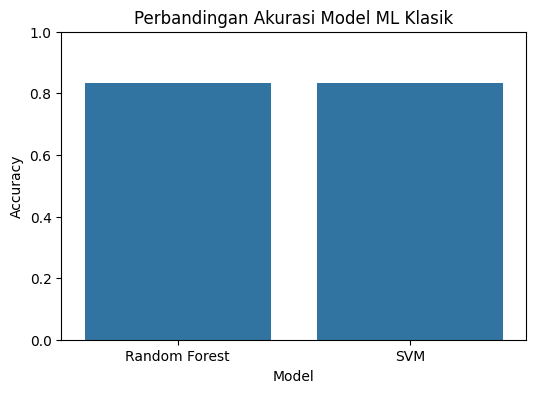

Akurasi Random Forest: 0.8333333333333334
Akurasi SVM: 0.8333333333333334


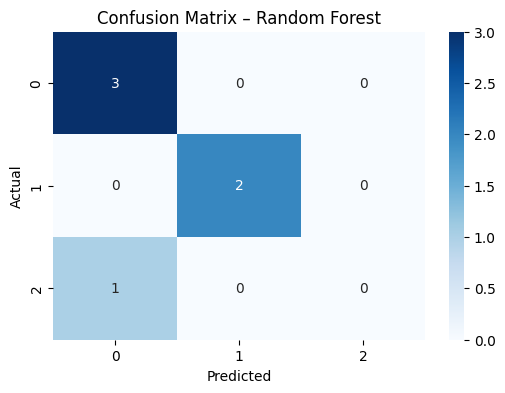

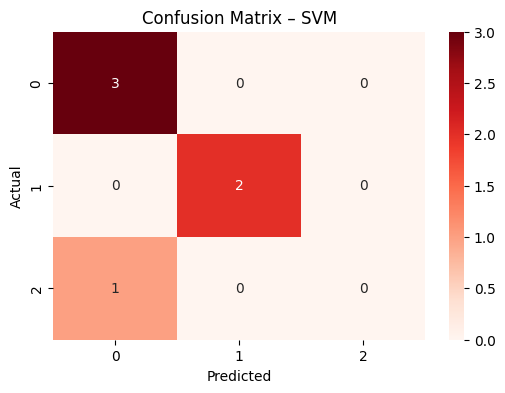

In [39]:
# ================================================================
# HASIL MODEL MACHINE LEARNING KLASIK (VISUALISASI)
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -----------------------------
# 1. AKURASI MODEL (BAR CHART)
# -----------------------------

rf_acc = accuracy_score(y_test, pred_rf)
svm_acc = accuracy_score(y_test, pred_svm)

model_names = ["Random Forest", "SVM"]
accuracies = [rf_acc, svm_acc]

plt.figure(figsize=(6,4))
sns.barplot(x=model_names, y=accuracies)
plt.ylim(0,1)
plt.title("Perbandingan Akurasi Model ML Klasik")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

print("Akurasi Random Forest:", rf_acc)
print("Akurasi SVM:", svm_acc)


# --------------------------------
# 2. CONFUSION MATRIX RANDOM FOREST
# --------------------------------

plt.figure(figsize=(6,4))
sns.heatmap(
    confusion_matrix(y_test, pred_rf),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------------------------------
# 3. CONFUSION MATRIX SVM
# ------------------------------

plt.figure(figsize=(6,4))
sns.heatmap(
    confusion_matrix(y_test, pred_svm),
    annot=True,
    fmt="d",
    cmap="Reds"
)
plt.title("Confusion Matrix – SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


BAGIAN 11 — DEEP LEARNING (DNN)

In [37]:
# ================================================================
# 11. DEEP LEARNING (DNN)
# ================================================================

import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = df["cluster"].nunique()

model = models.Sequential([
    layers.Input(shape=(X_scaled.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=8,
    verbose=1
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step - accuracy: 0.0972 - loss: 1.7880 - val_accuracy: 0.3333 - val_loss: 1.3340
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5556 - loss: 1.3723 - val_accuracy: 0.6667 - val_loss: 1.0652
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5972 - loss: 1.0165 - val_accuracy: 1.0000 - val_loss: 0.8268
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8472 - loss: 0.6073 - val_accuracy: 1.0000 - val_loss: 0.6600
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9028 - loss: 0.4399 - val_accuracy: 1.0000 - val_loss: 0.5119
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 1.0000 - loss: 0.2800 - val_accuracy: 1.0000 - val_loss: 0.3971
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 1.0000 - loss: 0.2303 - val_accuracy: 1.0000 - val_loss: 0.3098
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.2302 - val_accuracy: 1.0000 - val_loss:

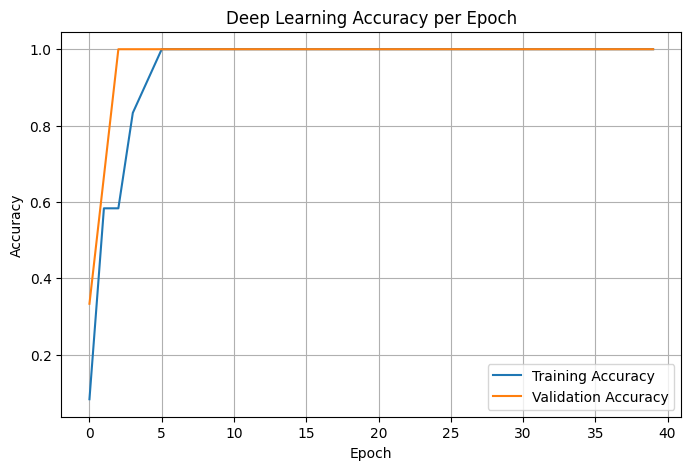

In [44]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Deep Learning Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


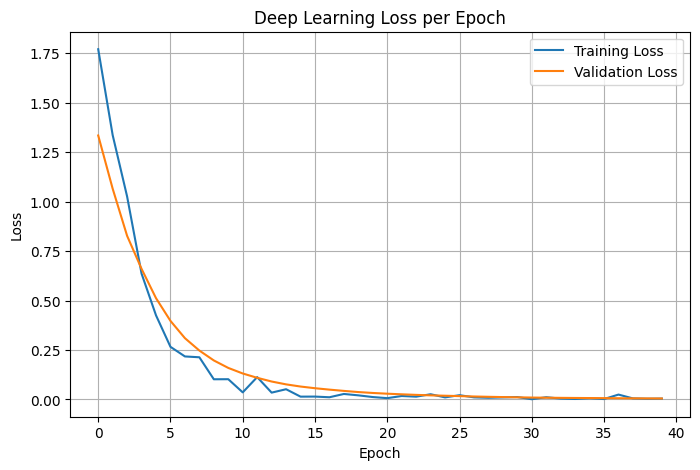

In [45]:
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Deep Learning Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

BAGIAN 12 — ANALISIS HASIL

In [38]:
# ================================================================
# 12. SIMPAN HASIL & KESIMPULAN
# ================================================================

df.to_csv(os.path.join(OUTPUT_FOLDER,"hasil_lengkap.csv"))

summary = {
    "total_sequence": len(df),
    "cluster_optimal": best_k,
    "rf_accuracy": accuracy_score(y_test, pred_rf),
    "svm_accuracy": accuracy_score(y_test, pred_svm),
    "dnn_accuracy": acc
}

with open(os.path.join(OUTPUT_FOLDER,"summary.json"), "w") as f:
    json.dump(summary, f, indent=4)

print("Ringkasan Hasil:")
print(summary)

Ringkasan Hasil:
{'total_sequence': 21, 'cluster_optimal': 4, 'rf_accuracy': 0.8333333333333334, 'svm_accuracy': 0.8333333333333334, 'dnn_accuracy': 1.0}
